# Golly Notebook - Re-Simulating Games

This notebook illustrates how to:
* Load data about a particular Golly game (various cups)
* Create a class to simulate that match, using the `gollyx-python` library
* Extend and instrument that class to record data about the match
* Generate and analyze results


In [1]:
import os, sys, subprocess, json, time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

xkcd_colors = sns.xkcd_rgb
GOLLY_GRAY = "#272B30"

## Loading Match Data

Start by loading match data from the `data/` dir:

In [2]:
def run_cmd(cmd_str):
    child = subprocess.Popen(cmd_str, shell=True, stdout=subprocess.PIPE)
    output = child.communicate()[0].decode()
    return output

print(run_cmd('ls ./data/'))

gollyx-dragon-data
gollyx-hellmouth-data
gollyx-klein-data
gollyx-pseudo-data
gollyx-rainbow-data
gollyx-star-data
gollyx-toroidal-data



Here is what the entire contents of a given FULL season of Golly looks like: schedule data, regular season data (schedule data plus scores/outcomes), braket data, postseason data (bracket data plus scores/outcomes), and teams.

In [3]:
cup = 'pseudo'
print(run_cmd(f'ls ./data/gollyx-{cup}-data/season0'))

bracket.json
postseason.json
schedule.json
season.json
seed.json
teams.json



Let's start with dessert: we'll grab Game 7 of the first ever Pseudo Cup, which was a devastating last-second defeat of the Oakland Bees by the Aptos Investigators.

In [4]:
post_file = os.path.join('data', f'gollyx-{cup}-data', 'season0', 'postseason.json')

with open(post_file, 'r') as f:
    season0_post = json.load(f)

In [5]:
# this should have been PCS but we were too lazy to change it :)
pseudo_cup = season0_post['HCS']

In [6]:
last_day = pseudo_cup[-1]
last_game = last_day[0]

Each game consists of a JSON structure with the following keys:

In [7]:
pprint(list(last_game.keys()))

['team1Name',
 'team2Name',
 'team1Abbr',
 'team2Abbr',
 'description',
 'season',
 'gameid',
 'isPostseason',
 'map',
 'team1Score',
 'team2Score',
 'generations',
 'team1Color',
 'team2Color',
 'day',
 'team1PostseasonWinLoss',
 'team2PostseasonWinLoss',
 'team1SeriesWinLoss',
 'team2SeriesWinLoss']


The most important key is the `map` key, which contains JSON describing the grid and initial conditions for the match, which is what we need to actually simulate it:

In [8]:
pprint(list(last_game['map'].keys()))

['patternName',
 'mapName',
 'mapZone1Name',
 'mapZone2Name',
 'mapZone3Name',
 'mapZone4Name',
 'initialConditions1',
 'initialConditions2',
 'url',
 'rows',
 'columns',
 'cellSize']


Here, each of the `*Name` fields are arbitrary labels; the `url` field provides the same information as the initial conditions fields; and the `cellSize` field is used when drawing the grid. So the only fields that we really need to simulate the match are:

* `initialConditions{1,2}`
* `rows`
* `columns`

## Extracting Initial Conditions

As we can see from the single game JSON structure, shown above for Game 7 of the first-ever Pseudo Cup, the key details are contained under the `maps` key, which is a key-value dictionary that contains the map initial conditions, as well as the map size.

Initial conditions are stored using list life schema, which would store a set of points (x0, y0a), (x0, y0b), (x1, y1a), (x1, y1b), (x1, y1c) as:

```
{
    "x0": [y0a, y0b],
    "x1": [y1a, y1b, y1c]
}
```

These are actually numbers, so it looks something more like 

```
{
    "0": [0, 2, 3, 8, 9, 10],
    "1": [1, 2, 4, 5, 8, 9]
}
```

All Pseudo Cup matches took place on a 100 x 120 grid:

In [9]:
print(last_game['map']['rows'])
print(last_game['map']['columns'])

100
120


In [10]:
print(json.loads(last_game['map']['initialConditions1']))

[{'28': [34, 35, 44, 45, 53, 54, 66, 67, 93, 94, 103, 104]}, {'29': [34, 35, 44, 45, 53, 54, 66, 67, 93, 94, 103, 104]}, {'32': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]}, {'33': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 9

## Loading `gollyx-python`

Once we've loaded the initial list life dictionary and grid sizes from the Golly data directory, we can initialize a new `gollyx-python` simulator of that size, with the right corresponding birth/survival (B/S) rules for this cellular automata.

(That should be taken care of by using the right `GOL` or `CA` class from the `gollyx_python` library.)

In [11]:
import gollyx_python

In [12]:
pprint(dir(gollyx_python))

['DragonCA',
 'HellmouthGOL',
 'KleinGOL',
 'RainbowGOL',
 'StarGOLGenerations',
 'ToroidalGOL',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'dragon_rules',
 'hellmouthlife',
 'kleinlife',
 'manager',
 'pylife',
 'starlife']


In [13]:
pprint(dir(gollyx_python.manager))

['Dragon1D',
 'DragonCA',
 'HellmouthBinaryLife',
 'HellmouthGOL',
 'KleinBinaryLife',
 'KleinGOL',
 'RainbowGOL',
 'RainbowQuaternaryLife',
 'StarBinaryGenerationsCA',
 'StarGOLGenerations',
 'ToroidalBinaryLife',
 'ToroidalGOL',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'json']


Unfortunately there is no Pseudo Cup class, but we'll show how we can easily extend the `HellmouthGOL` base class to make a new Cup class if one isn't available.

In [14]:
class PseudoGOL(gollyx_python.manager.HellmouthGOL):
    rule_b = [3, 5, 7]
    rule_s = [2, 3, 8]
    
    def __init__(self, *args, **kwargs):
        super().__init__(
            rule_b=self.rule_b, 
            rule_s=self.rule_s, 
            neighbor_color_legacy_mode=False, 
            *args, **kwargs
        )

Now load the initial condition data from Game 7, Investigators vs Bees, and use it to initialize a Pseudo Cup Game of Life simulation and make sure the constructor works as expected:

In [15]:
ic1 = last_game['map']['initialConditions1']
ic2 = last_game['map']['initialConditions2']

In [16]:
gol = PseudoGOL(
    s1=ic1,
    s2=ic2,
    rows=100,
    columns=120,
    halt=False,
)

To instrument the Pseudo Cup Game of Life to record the number of live cells for each team at each generation, we'll create a new class that extends the regular Game of Life simulator. This class extends the constructor so that it record the number of live cells in the initial state, and record the number of live cells at each subsequent generation.

In [17]:
class PseudoGOL_Instrumented(PseudoGOL):
    live_counts_keys = ['generation','victoryPct','liveCells1','liveCells2', 'last3']
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.live_counts = []
        new_stats = self.life.get_stats()
        new_live_count = {k : new_stats[k] for k in self.live_counts_keys}
        self.live_counts.append(new_live_count)

    def next_step(self):
        new_stats = super().next_step()
        new_live_count = {k : new_stats[k] for k in self.live_counts_keys}
        self.live_counts.append(new_live_count)
        return new_stats

Again, we initialize this with Game 7 Investigators vs Bees:

In [18]:
inst = PseudoGOL_Instrumented(
    s1=ic1,
    s2=ic2,
    rows=100,
    columns=120,
    halt=False,
)

Now, we're ready to start the simulation. Let's just do 100 steps, to begin with:

In [19]:
N = 100

tic = time.time()
for i in range(N):
    inst.next_step()
toc = time.time()
diff = toc-tic

print(f"{N} steps took {diff:0.2f} s")

100 steps took 10.10 s


Let's also collect some information about the two teams that we can use to stylize and label the graph:

In [20]:
print(list(last_game.keys()))

['team1Name', 'team2Name', 'team1Abbr', 'team2Abbr', 'description', 'season', 'gameid', 'isPostseason', 'map', 'team1Score', 'team2Score', 'generations', 'team1Color', 'team2Color', 'day', 'team1PostseasonWinLoss', 'team2PostseasonWinLoss', 'team1SeriesWinLoss', 'team2SeriesWinLoss']


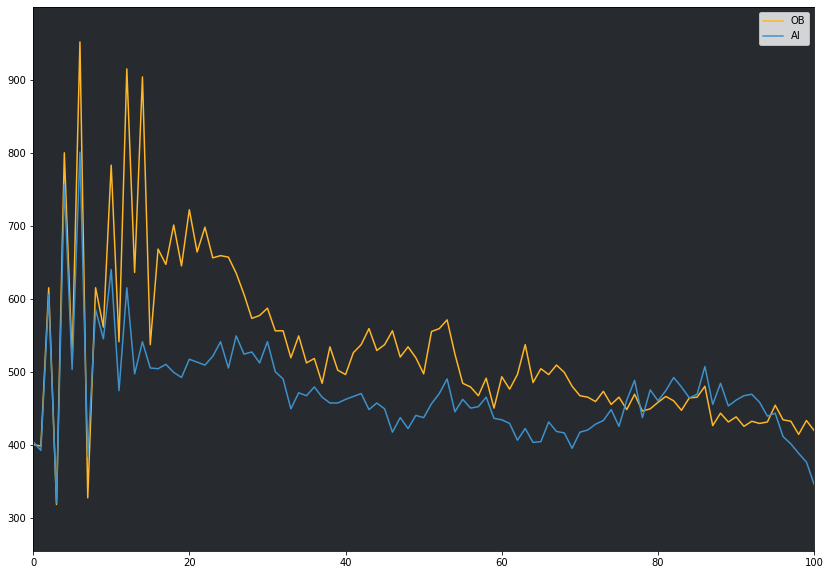

In [21]:
t1n = last_game['team1Name']
t1a = last_game['team1Abbr']
t1c = last_game['team1Color']

t2n = last_game['team2Name']
t2a = last_game['team2Abbr']
t2c = last_game['team2Color']

s1 = [d['liveCells1'] for d in inst.live_counts]
s2 = [d['liveCells2'] for d in inst.live_counts]

x = range(0, len(s1))

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.set_xlim(0, N)
ax.set_ylim(0.80*min(min(s1), min(s2)), 1.05*max(max(s1), max(s2)))

ax.plot(x, s1, label = t1a, color = t1c)
ax.plot(x, s2, label = t2a, color = t2c)

ax.set_facecolor(GOLLY_GRAY)
ax.legend()
plt.show()

Now we're ready to run the simulation until it completes. The number of generations in Game 7 was pretty close to the minimum of 1000 so it shouldn't take long to run:

In [22]:
last_game['generations']

1200

This time around, construct a Pseudo GOL object that has `halt = True`. This assembles a game of life object with a boolean, `running`, that is set to True initially. This boolean is only set to false when the game of life is finished and one of the teams has achieved a victory condition.

In [23]:
inst = PseudoGOL_Instrumented(
    s1=ic1,
    s2=ic2,
    rows=100,
    columns=120,
    halt=True,
)

print(inst.running)

True


In [24]:
N = 0

tic = time.time()
while inst.running:
    N += 1
    inst.next_step()
toc = time.time()
diff = toc-tic

print(f"{N} steps took {diff:0.2f} s")

1200 steps took 34.29 s


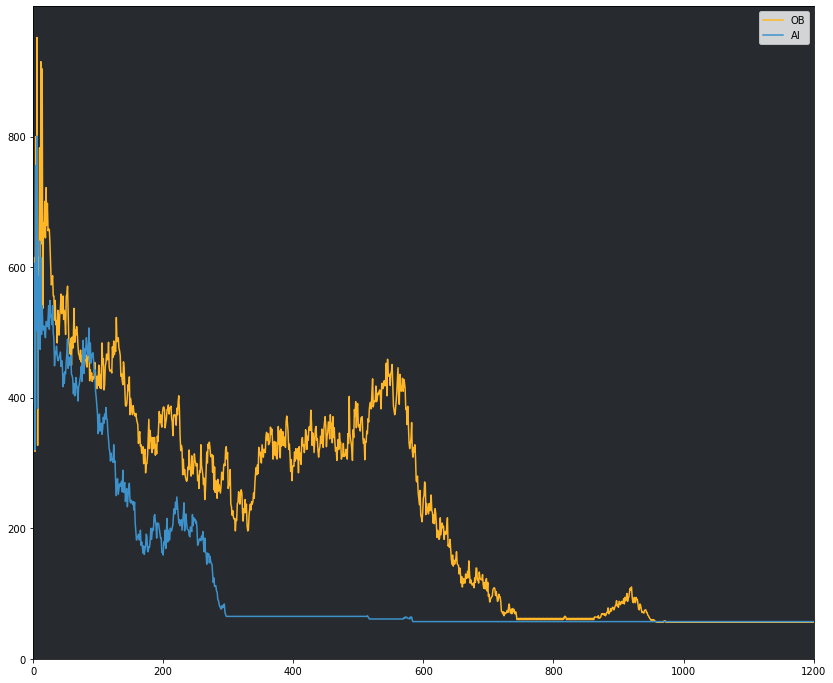

In [25]:
t1n = last_game['team1Name']
t1a = last_game['team1Abbr']
t1c = last_game['team1Color']

t2n = last_game['team2Name']
t2a = last_game['team2Abbr']
t2c = last_game['team2Color']

s1 = [d['liveCells1'] for d in inst.live_counts]
s2 = [d['liveCells2'] for d in inst.live_counts]

x = range(0, len(s1))

fig, ax = plt.subplots(1, 1, figsize=(14, 12))

ax.set_xlim(0, len(x))
ax.set_ylim(0, 1.05*max(max(s1), max(s2)))
#ax.set_xlim(500, len(x))
#ax.set_ylim(50, 300)

ax.plot(x, s1, label = t1a, color = t1c)
ax.plot(x, s2, label = t2a, color = t2c)

ax.set_facecolor(GOLLY_GRAY)
ax.legend()
plt.show()

## Zooming In on the End of the Match

Let's take a look at the end of the match and see what's going on.

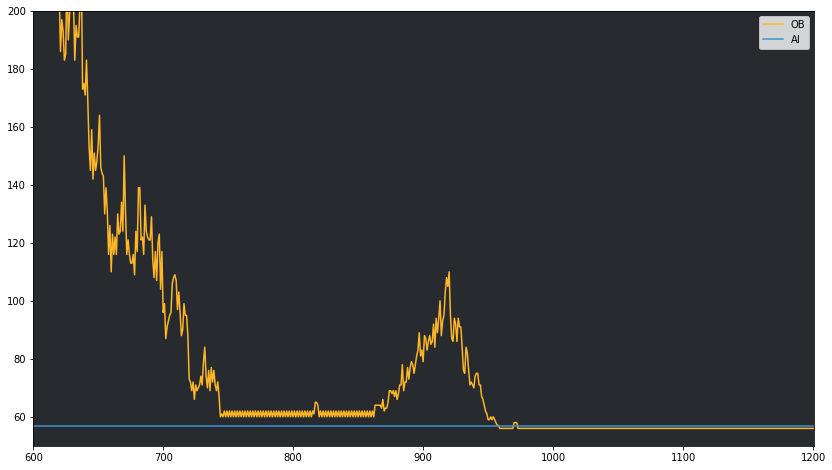

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

ax.set_xlim(600, len(x))
ax.set_ylim(50, 200)

ax.plot(x, s1, label = t1a, color = t1c)
ax.plot(x, s2, label = t2a, color = t2c)

ax.set_facecolor(GOLLY_GRAY)
ax.legend()
plt.show()

You can see the big choke here. The Oakland Bees were settled at around 750, a few points of the Aptos Investigators, and were steady for almost 100 generations, but then they started growing again, and then they shrank again, and when they settled into their final formation, the Bees were a single point shy of the Aptos Investigators, costing the Bees the first-ever Pseudo Cup championship.

## Instrumenting the Stopping Criteria

The next thing we want to look at is the the stopping criteria, to see just how close the OB were to victory before they started shifting around again.

To do this, we create a new instrumented class, that looks similar to the prior one, but this time it extends a hook function that was added where the Game of Life checks the stopping criteria. This will allow us visibility into what was happening with the stopping criteria during the match.

In [27]:
# NOTE: Must match the function used by PseudoGOL, or its parent HellmouthGOL
SMOL = 1e-12
def _diff(a, b):
    return (abs(b - a) / abs(a + SMOL))

In [28]:
victory = []
stopping_criteria1 = []
stopping_criteria2 = []
for d in inst.live_counts:
    if len(d['last3']) < 3 or d['last3'] == [0, 0, 0]:
        victory.append(0)
        stopping_criteria1.append(0)
        stopping_criteria2.append(0)
    else:
        last3_0 = d['last3'][0]
        last3_1 = d['last3'][1]
        last3_2 = d['last3'][2]
        victory.append(last3_0)
        stopping_criteria1.append(_diff(last3_0, last3_1))
        stopping_criteria2.append(_diff(last3_1, last3_2))

In [29]:
print(len(s1))
print(len(x))
print(len(stopping_criteria1))

1201
1201
1201


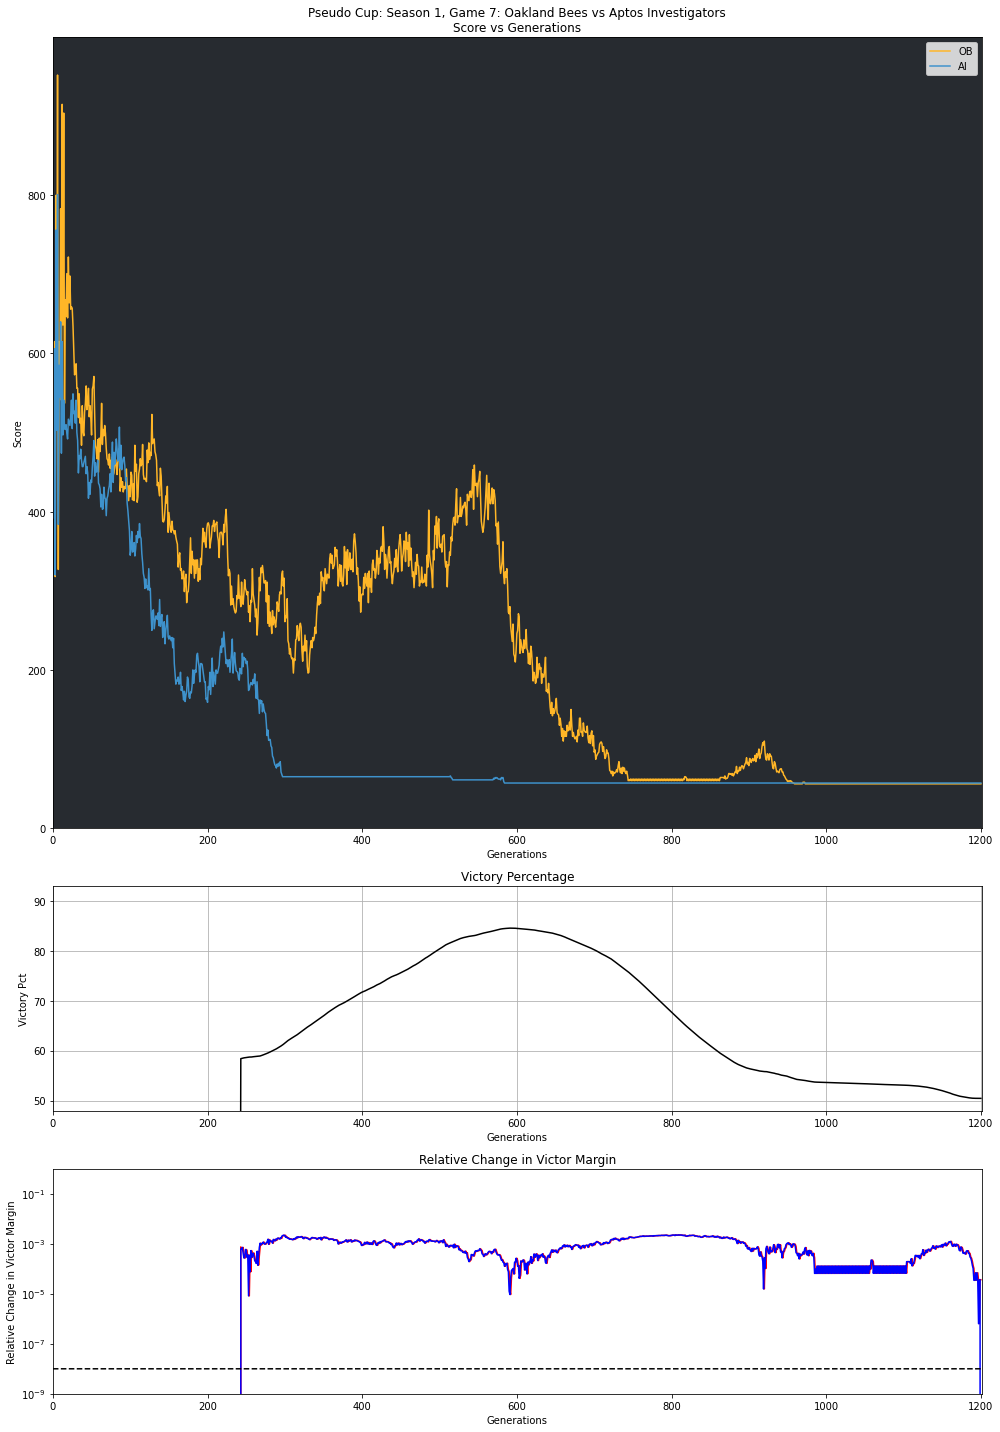

In [30]:
t1n = last_game['team1Name']
t1a = last_game['team1Abbr']
t1c = last_game['team1Color']

t2n = last_game['team2Name']
t2a = last_game['team2Abbr']
t2c = last_game['team2Color']

s1 = [d['liveCells1'] for d in inst.live_counts]
s2 = [d['liveCells2'] for d in inst.live_counts]

x = range(0, len(s1))

fig, axes = plt.subplots(1, 1, figsize=(14, 20))

ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)
ax2 = plt.subplot2grid((5,1),(3,0))
ax3 = plt.subplot2grid((5,1),(4,0))

t0 = 0
#t0 = 500

# ---------

ax1.set_xlim(t0, len(x))

# if t0 = 0
ax1.set_ylim(0, 1.05*max(max(s1), max(s2)))
# if t0 = 500
#ax1.set_ylim(50, 300)

ax1.plot(x, s1, label = t1a, color = t1c)
ax1.plot(x, s2, label = t2a, color = t2c)

ax1.set_title('Pseudo Cup: Season 1, Game 7: Oakland Bees vs Aptos Investigators\nScore vs Generations')
ax1.set_xlabel('Generations')
ax1.set_ylabel('Score')

# ---------
# victory pct

ax2.set_xlim(t0, len(x))
ax2.set_ylim(1e-9, 1)

ax2.plot(x, victory, '-k')

ax2.set_ylim(0.95*min(victory[300:]), 1.1*max(victory[300:]))
ax2.grid('on')

ax2.set_title('Running Average Victory Pct')
ax2.set_xlabel('Generations')
ax2.set_ylabel('Running Average Victory Pct')

# ---------
# rel diff victory

ax3.set_xlim(t0, len(x))
ax3.set_ylim(1e-9, 1)

ax3.semilogy(x, stopping_criteria1, '-r')
ax3.semilogy(x, stopping_criteria2, '-b')
ax3.semilogy(x, [1e-8,]*len(x), '--k')

#ax3.set_title('Change in Mean Square Live Cells')
ax3.set_title('Relative Change in Victor Margin')
ax3.set_xlabel('Generations')
#ax3.set_ylabel('Relative Change in Mean Square Live Cells')
ax3.set_ylabel('Relative Change in Victor Margin')

# ----------

ax1.set_facecolor(GOLLY_GRAY)
ax1.legend()

fig.tight_layout()
plt.show()

## Functionalizing It

If we're going to analyze a bunch of games, we should do a few things:

* rewrite this as a function, starting with the game JSON and ending with plots and other useful info
* parameterize the variables and labels and such
* add ability to load and dump games that have already been simulated - giant pool, indexed by UUID, probably

In [31]:
# NOTE: Must match the function used by PseudoGOL, or its parent HellmouthGOL
def _pseudo_diff(a, b):
    SMOL = 1e-12
    return (abs(b - a) / abs(a + SMOL))

In [32]:
def get_pseudo_cup_miniseason(season0):
    """Get the miniseason (list of days, one game per day) for the Pseudo Cup playoffs"""
    cup = 'pseudo'
    post_file = os.path.join('data', f'gollyx-{cup}-data', f'season{season0}', 'postseason.json')
    with open(post_file, 'r') as f:
        post = json.load(f)
    return post

In [51]:
def make_pseudo_cup_plot(game_json):
    ic1 = game_json['map']['initialConditions1']
    ic2 = game_json['map']['initialConditions2']
    descr = game_json['description']

    inst = PseudoGOL_Instrumented(
        s1=ic1,
        s2=ic2,
        rows=100,
        columns=120,
        halt=True,
    )
    
    print(f"Starting simulation of game: {descr}")
    
    N = 0
    tic = time.time()
    while inst.running:
        N += 1
        inst.next_step()
    toc = time.time()
    diff = toc-tic

    print(f"{N} steps took {diff:0.2f} s")
    
    
    t1n = game_json['team1Name']
    t1a = game_json['team1Abbr']
    t1c = game_json['team1Color']
    t1s = game_json['team1Score']

    t2n = game_json['team2Name']
    t2a = game_json['team2Abbr']
    t2c = game_json['team2Color']
    t2s = game_json['team2Score']

    descr = game_json['description']

    s1 = [d['liveCells1'] for d in inst.live_counts]
    s2 = [d['liveCells2'] for d in inst.live_counts]
    
    
    victory = []
    stopping_criteria1 = []
    stopping_criteria2 = []
    for d in inst.live_counts:
        if len(d['last3']) < 3 or d['last3'] == [0, 0, 0]:
            victory.append(0)
            stopping_criteria1.append(0)
            stopping_criteria2.append(0)
        else:
            last3_0 = d['last3'][0]
            last3_1 = d['last3'][1]
            last3_2 = d['last3'][2]
            victory.append(last3_0)
            stopping_criteria1.append(_diff(last3_0, last3_1))
            stopping_criteria2.append(_diff(last3_1, last3_2))
    
    
    x = range(0, len(s1))

    fig, axes = plt.subplots(1, 1, figsize=(14, 20))

    ax1 = plt.subplot2grid((5,1),(0,0),rowspan=3, fig=fig)
    ax2 = plt.subplot2grid((5,1),(3,0))
    ax3 = plt.subplot2grid((5,1),(4,0))

    t0 = 0
    #t0 = 500

    # ---------

    ax1.set_xlim(t0, len(x))

    # if t0 = 0
    ax1.set_ylim(0, 1.05*max(max(s1), max(s2)))
    # if t0 = 500
    #ax1.set_ylim(50, 300)

    ax1.plot(x, s1, label = t1n + f"({t1s})", color = t1c)
    ax1.plot(x, s2, label = t2n + f"({t2s})", color = t2c)

    ax1.set_title(f'{descr}: {t1n} vs. {t2n}\nScore vs Generations')
    ax1.set_xlabel('Generations')
    ax1.set_ylabel('Score')

    # ---------
    # victory pct

    ax2.set_xlim(t0, len(x))
    ax2.set_ylim(1e-9, 1)

    ax2.plot(x, victory, '-k')

    ax2.set_ylim(0.95*min(victory[300:]), 1.1*max(victory[300:]))
    ax2.grid('on')

    ax2.set_title('Running Average Victory Pct')
    ax2.set_xlabel('Generations')
    ax2.set_ylabel('Running Average Victory Pct')


    # ---------
    # rel diff victory

    ax3.set_xlim(t0, len(x))
    ax3.set_ylim(1e-9, 1)

    ax3.semilogy(x, stopping_criteria1, '-r')
    ax3.semilogy(x, stopping_criteria2, '-b')
    ax3.semilogy(x, [1e-8,]*len(x), '--k')

    #ax3.set_title('Change in Mean Square Live Cells')
    ax3.set_title('Relative Change in Victory Pct')
    ax3.set_xlabel('Generations')
    #ax3.set_ylabel('Relative Change in Mean Square Live Cells')
    ax3.set_ylabel('Relative Change in Victor Pct')
    ax3.grid('on')
    
    # ----------

    ax1.set_facecolor(GOLLY_GRAY)
    ax1.legend()

    fig.tight_layout()
    plt.show()

In [52]:
season0_post = get_pseudo_cup_miniseason(0)
pcs = season0_post['HCS']

Starting simulation of game: Game 1, Pseudo Cup
1198 steps took 46.74 s


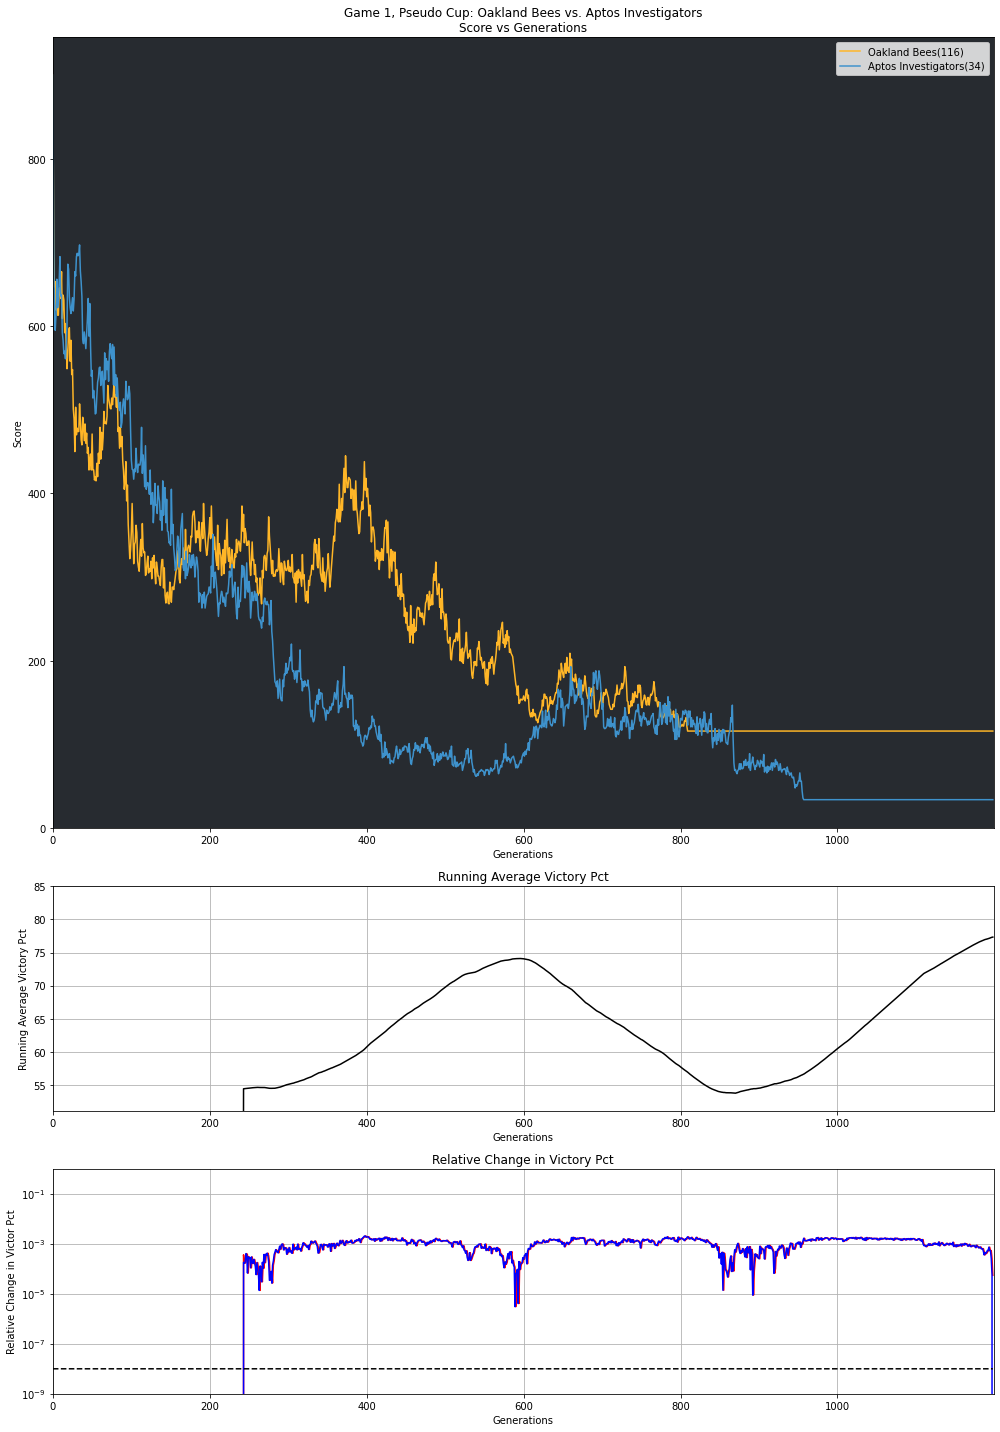

In [53]:
game1 = pcs[0][0]
make_pseudo_cup_plot(game1)

Starting simulation of game: Game 2, Pseudo Cup
1183 steps took 40.51 s


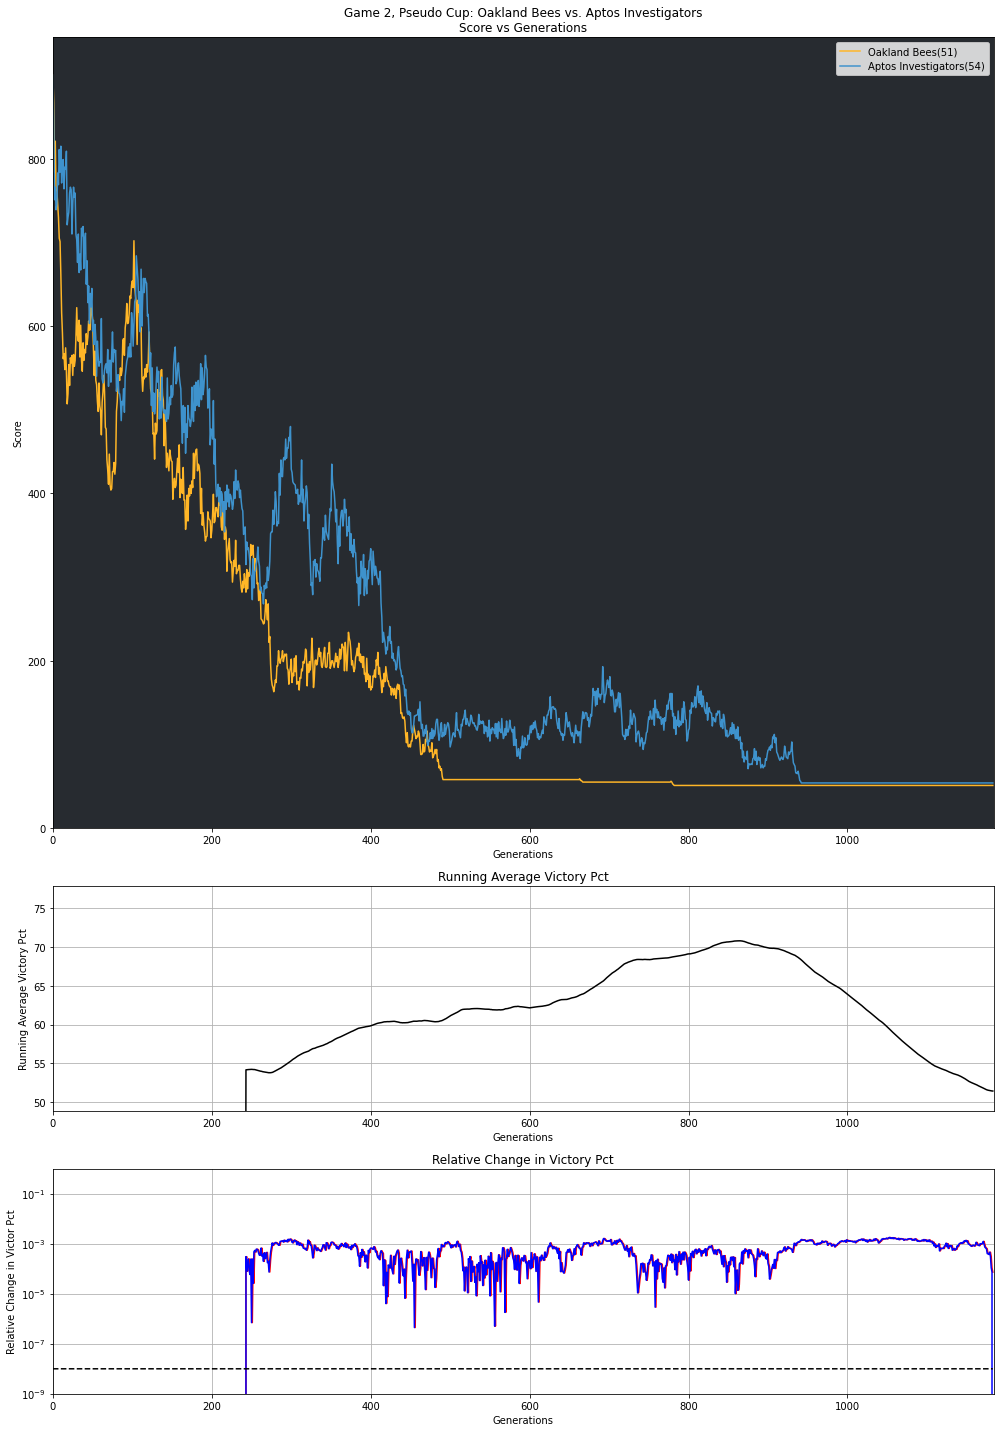

In [54]:
game2 = pcs[1][0]
make_pseudo_cup_plot(game2)

Starting simulation of game: Game 3, Pseudo Cup
1128 steps took 15.61 s


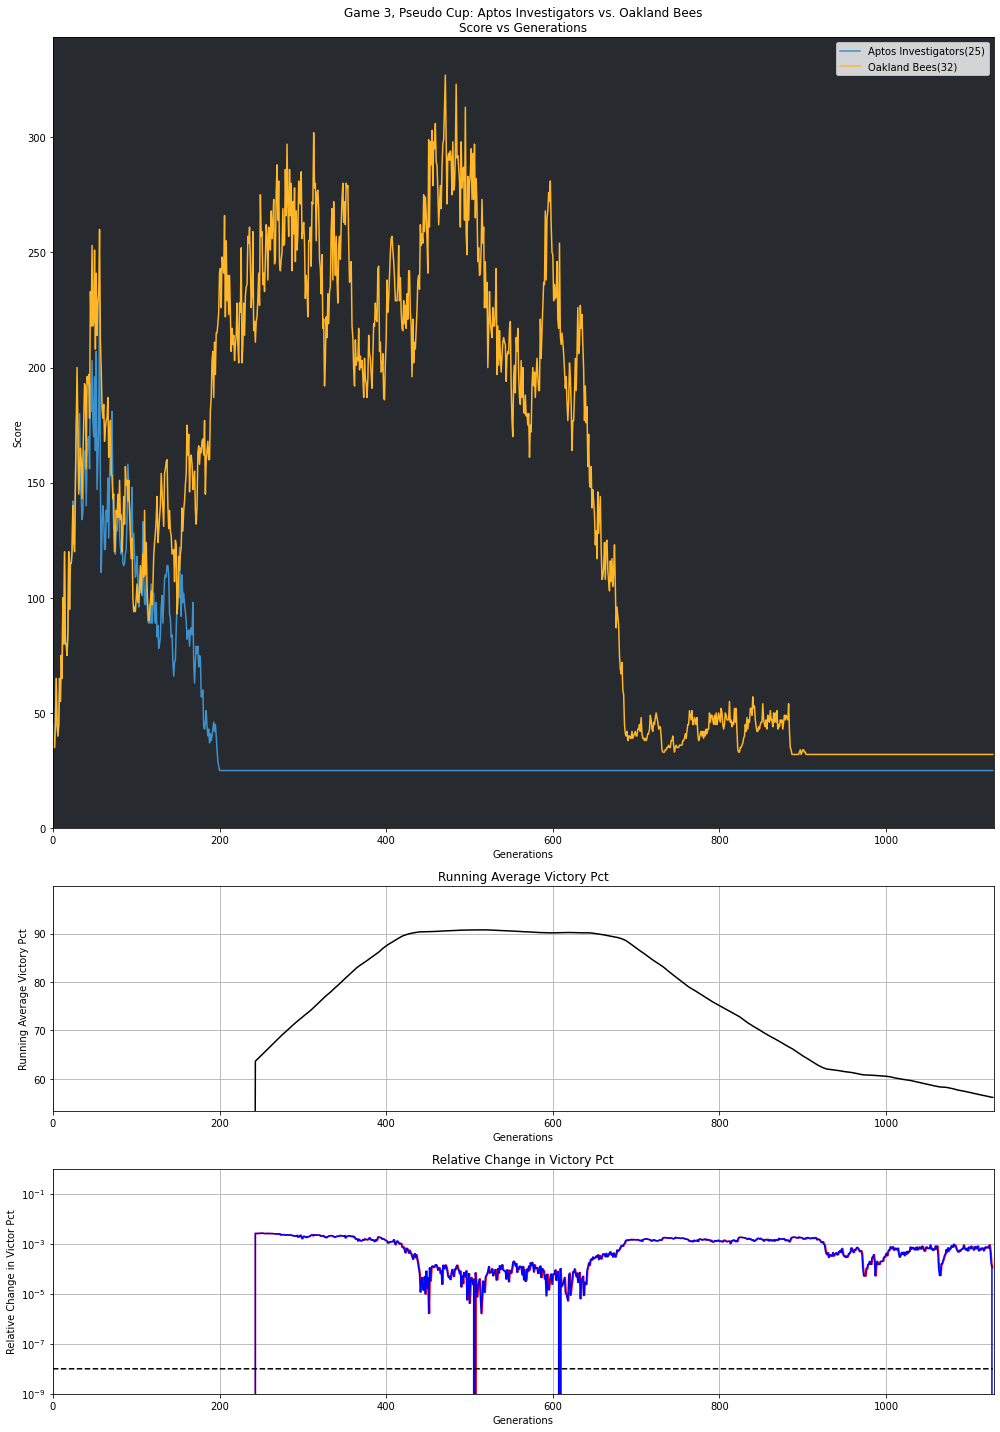

In [55]:
game3 = pcs[2][0]
make_pseudo_cup_plot(game3)

Starting simulation of game: Game 4, Pseudo Cup
1247 steps took 68.99 s


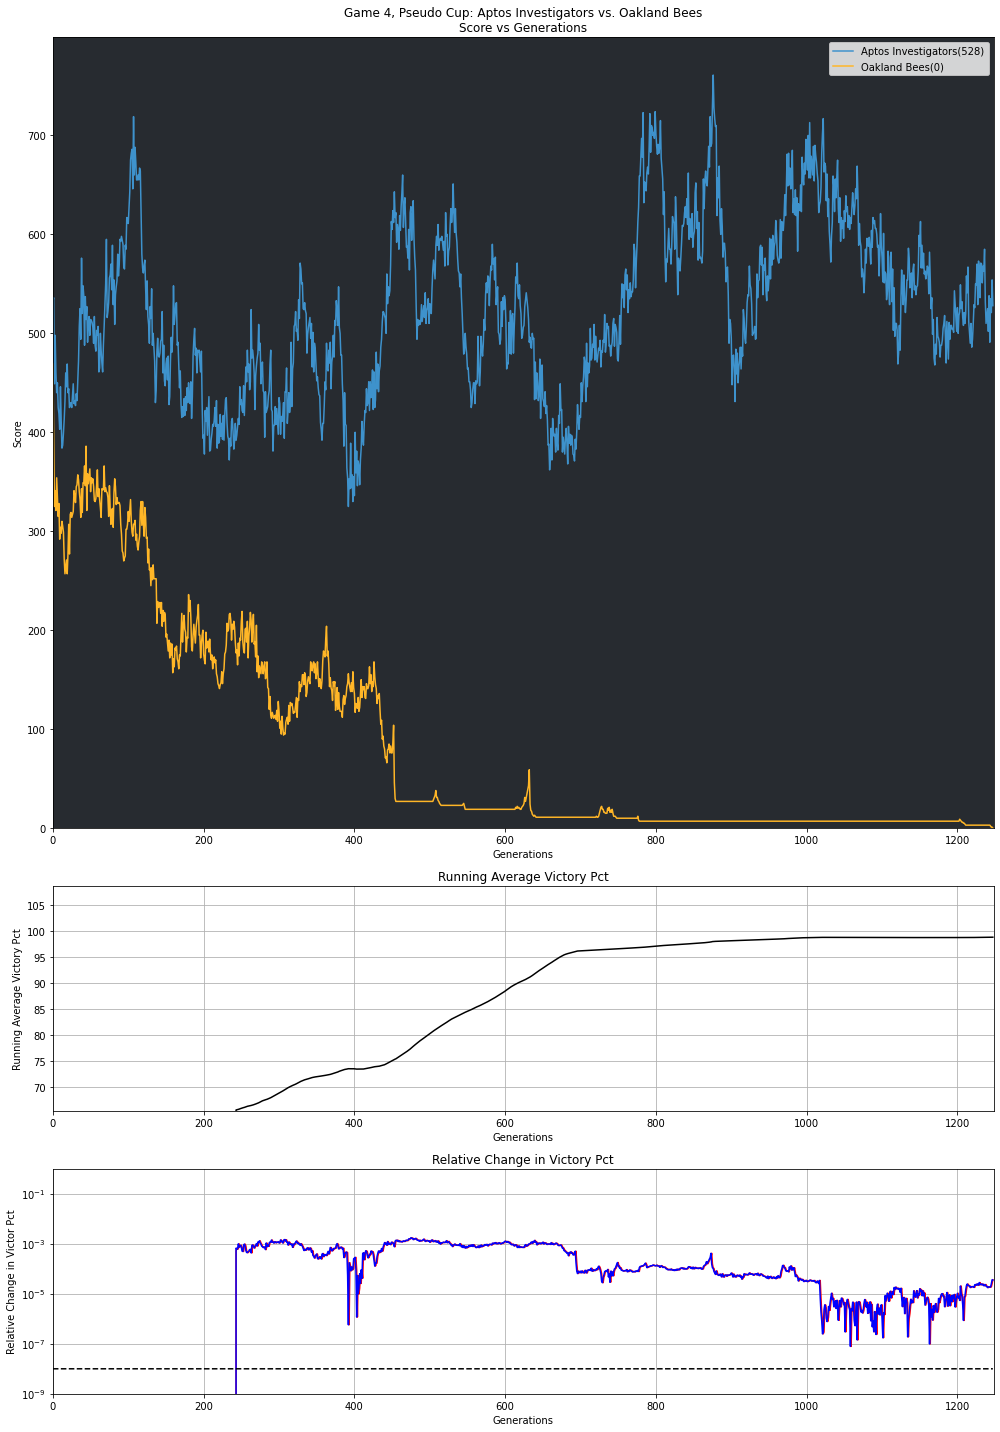

In [56]:
game4 = pcs[3][0]
make_pseudo_cup_plot(game4)

Starting simulation of game: Game 5, Pseudo Cup
1258 steps took 84.63 s


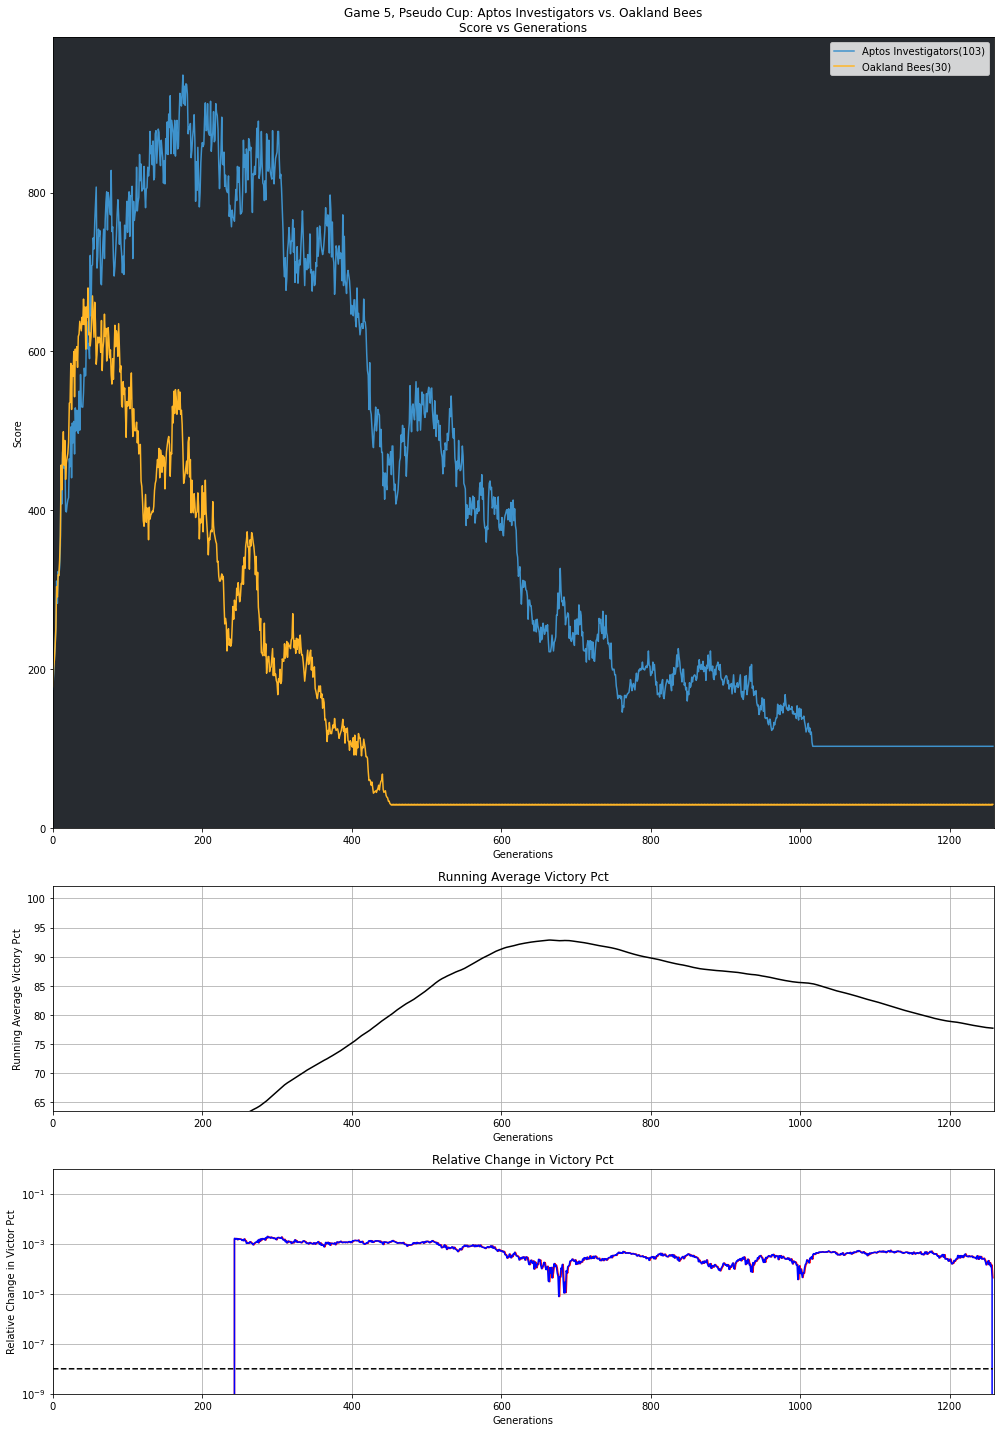

In [57]:
game5 = pcs[4][0]
make_pseudo_cup_plot(game5)

Starting simulation of game: Game 6, Pseudo Cup
2317 steps took 85.87 s


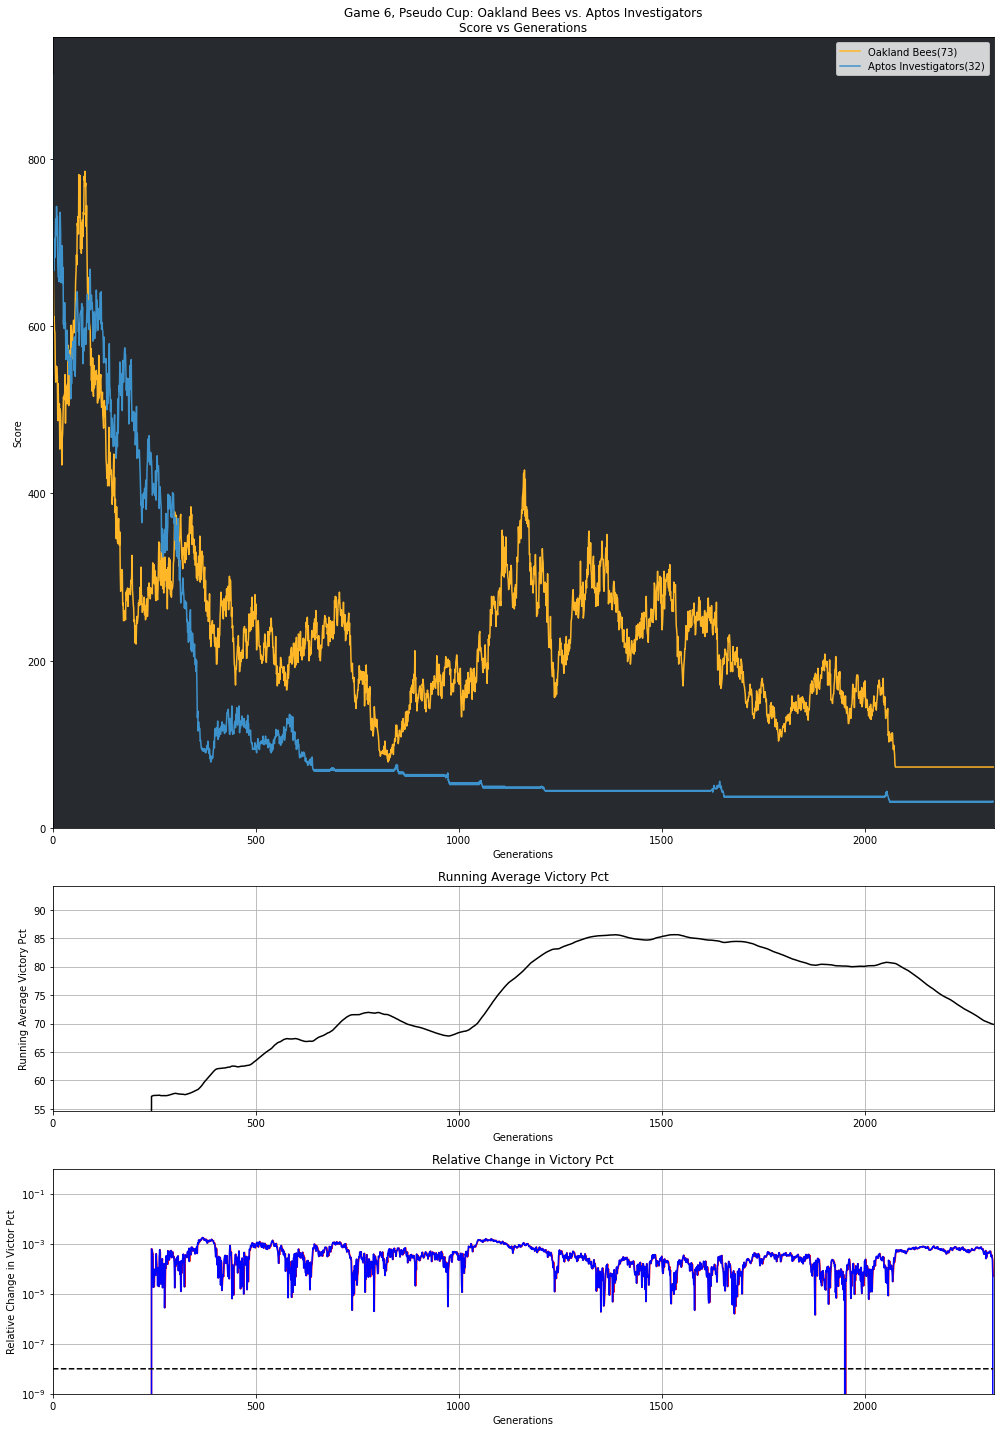

In [58]:
game6 = pcs[5][0]
make_pseudo_cup_plot(game6)

Starting simulation of game: Game 7, Pseudo Cup
1200 steps took 32.20 s


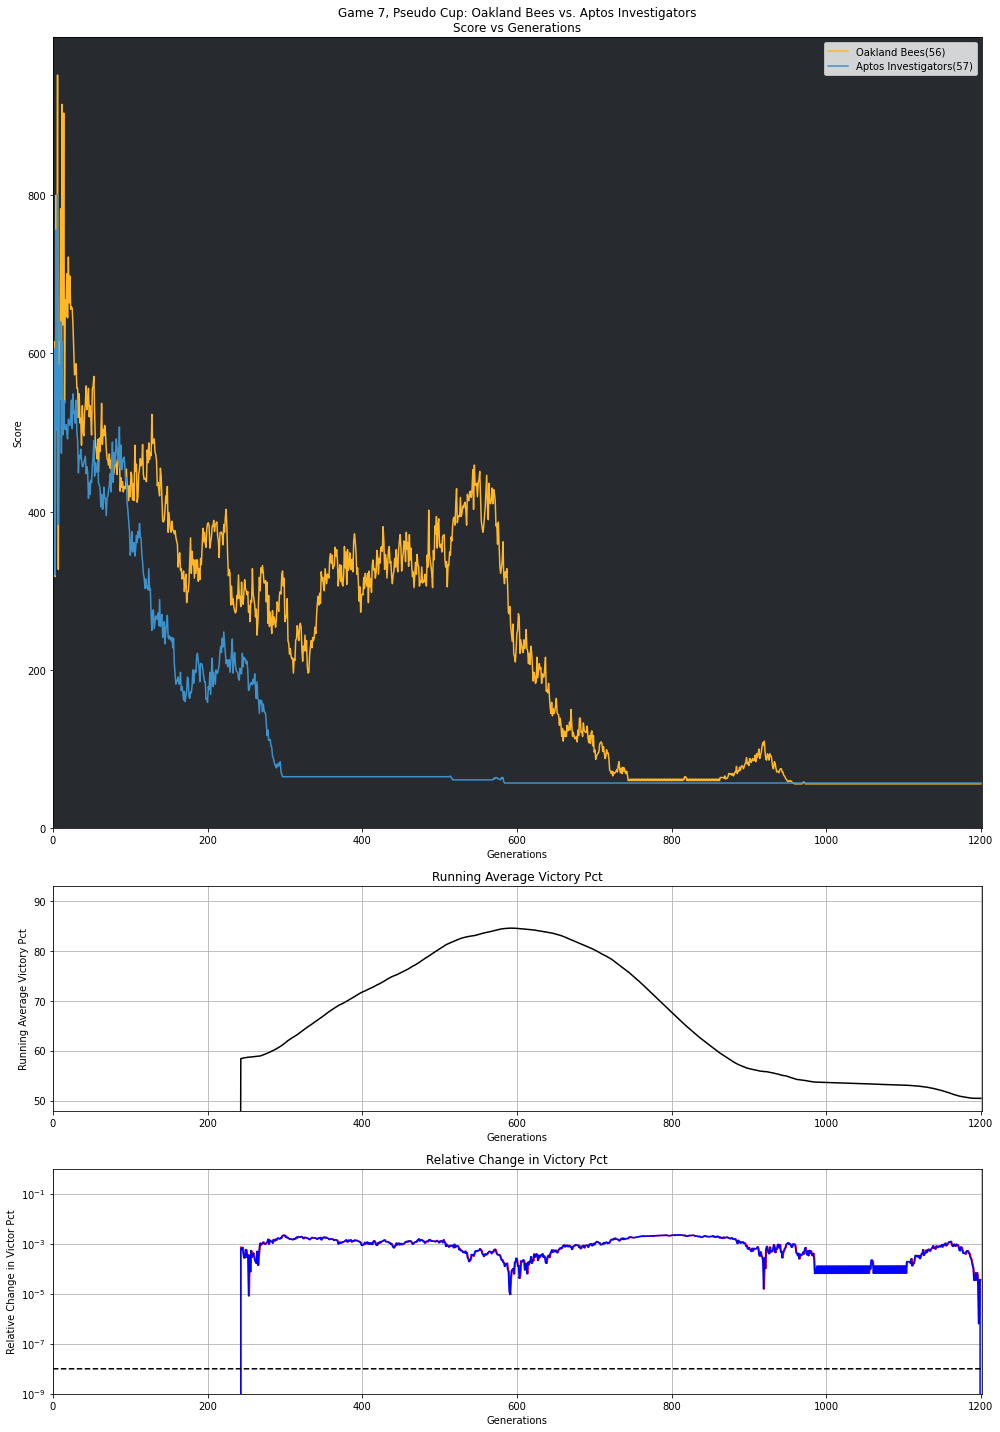

In [59]:
game7 = pcs[6][0]
make_pseudo_cup_plot(game7)